In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker 


In [2]:
'''
Plotting libraries
'''
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

'''
What we'll need for analysis, clustering, etc.
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

'''
Of course the powerful RDKIT for cheminformatics <3
'''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

'''
Some utilities
'''
import progressbar
from math import pi

%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)

# 1) Leer la base de datos como un dataframe

In [5]:
df = pd.read_csv('database.txt', sep='\t')

In [6]:
df

,smiles,id
0,CCC(C)(NCC1=C(C)N=C(C(=O)OC)S1)C1=NC=CS1,Z3802908175
1,CC(CN(C)C(=O)C1(O)CCOC1)N(C)C(=O)C1=CC=C2NC(=O...,PV-006986126441
2,CC1=C(C(=O)N2CCC3(CNC(=O)C4CC4)CCCCC23)OC(C(F)...,PV-004304002588
3,CC1=CN(C2CCCN(S(=O)(=O)C3=NC(Cl)=C(C#N)N3C)C2)...,Z3616737478
4,COCC1=CC=CC(C(=O)N2C[C@@H]3OCC[C@@H]32)=C1C |&...,Z5525936518
...,...,...
59647,COc1cc(CCO[C@@H]2O[C@H](CO[C@@H]3O[C@H](CO)[C@...,255227116
59648,Cc1ccc2c(c1O)C(=O)c1ccc(O[C@@H]3O[C@H](CO[C@@H...,140283059
59649,[N-]=[N+]=NCCOCCOCCOCCOCCOCCNC(=O)CN1CCN(CC(=O...,1857523819
59650,Nc1ccc(C[C@@H]2CN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=...,34602851


# Representar algunas moleculas al azar en una imagen

Sugerencia: 
1) Usar df.sample(N) para generar un set random de N moleculas
2) investigar como representar en un grid las moleculas con PandasTools.AddMoleculeColumnToFrame y PandasTools.FrameToGridImage

In [7]:
sample = df.sample(500)

In [8]:
PandasTools.AddMoleculeColumnToFrame(sample, smilesCol='smiles')

/home/ccgroup/anaconda3/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


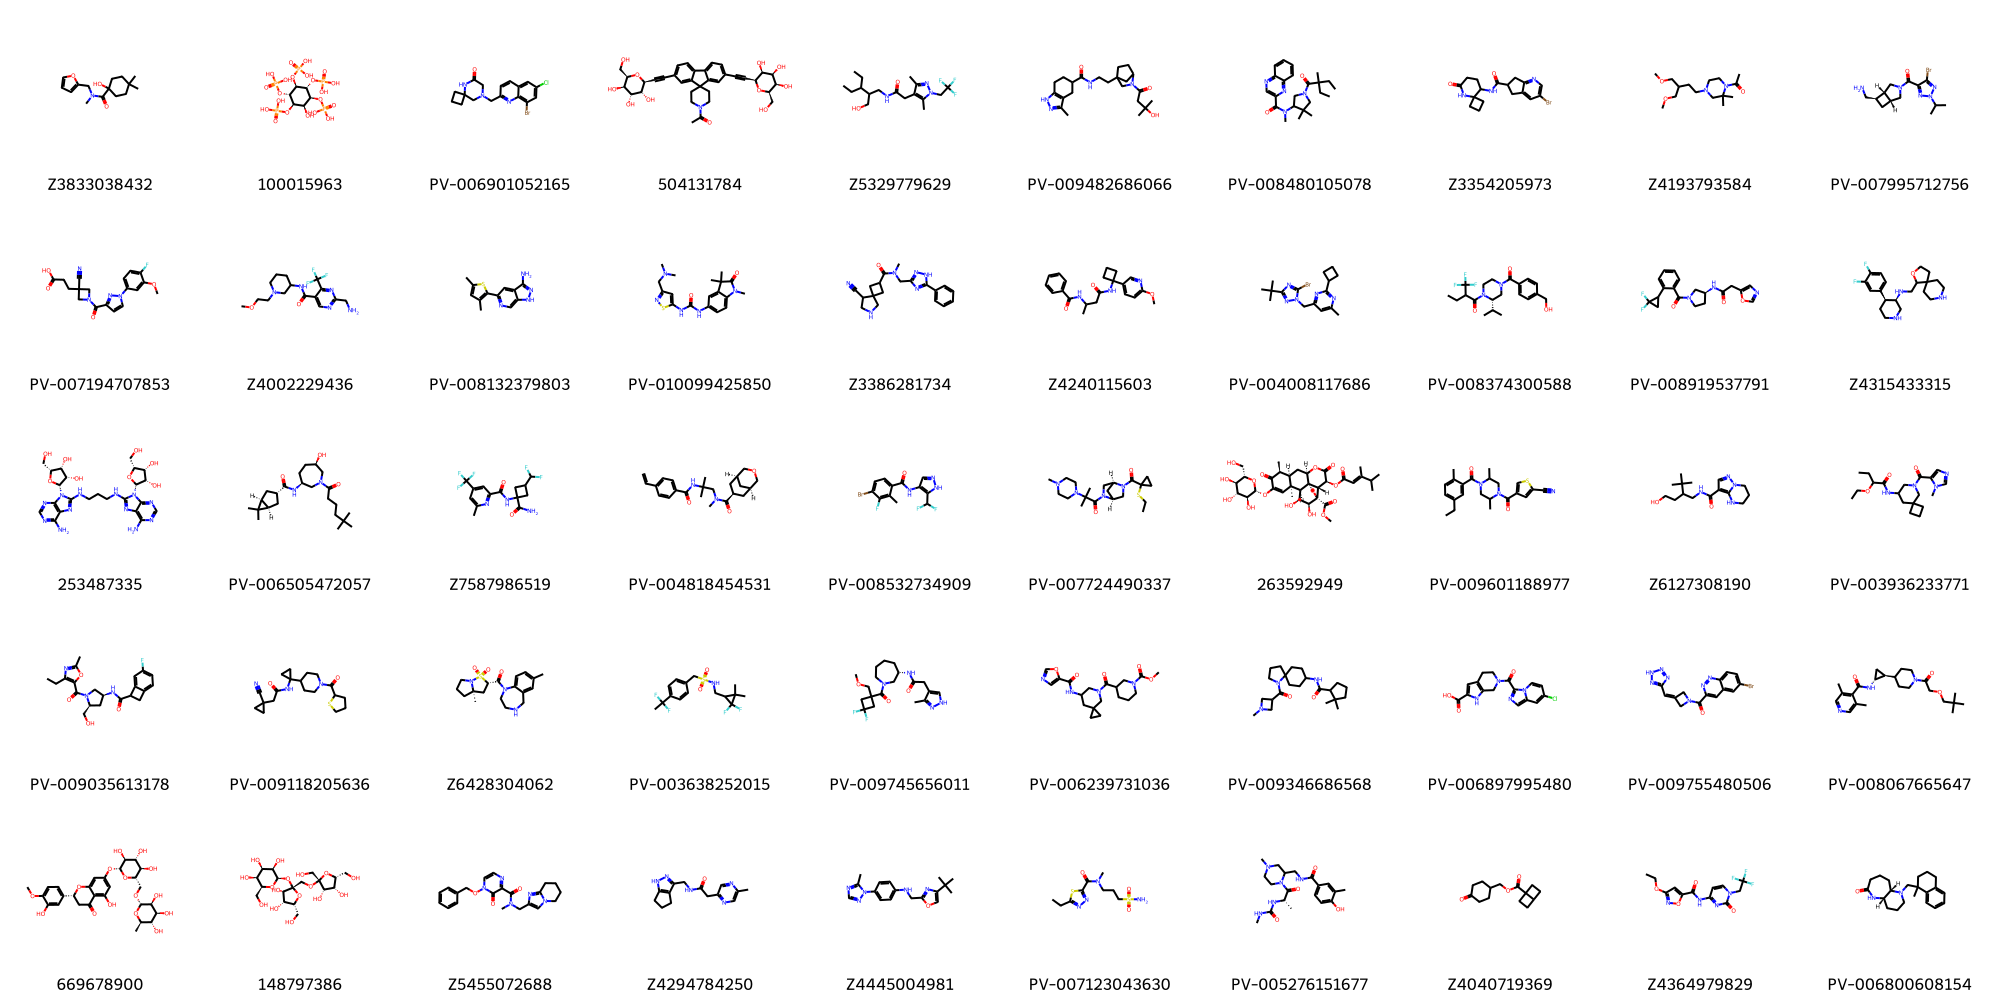

In [9]:
PandasTools.FrameToGridImage(sample.head(150), legendsCol='id', molsPerRow=10)

# Creamos un dataframe con toda la informaciópn para comenzar a trabajar

Crear una lista con los smiles para calcular las estructuras moleculares con chem.MolFromSmiles y Chem.AddHs.
La lista se puede crear con: list(df["Columna"])

In [10]:
all_smiles = list(df["smiles"])

In [11]:
hmols = []
bar=progressbar.ProgressBar(maxval=len(all_smiles))

for i,smil in enumerate(all_smiles) :
    
    mol = Chem.MolFromSmiles(smil) 
    
    hmol = Chem.AddHs(mol) 
    hmols.append(hmol)
     
    bar.update(i+1)


  0% (0 of 59652) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (705 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:00:08
  2% (1398 of 59652) |                   | Elapsed Time: 0:00:00 ETA:   0:00:08
  3% (2106 of 59652) |                   | Elapsed Time: 0:00:00 ETA:   0:00:08
  4% (2808 of 59652) |                   | Elapsed Time: 0:00:00 ETA:   0:00:08
  5% (3507 of 59652) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:08
  7% (4213 of 59652) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:07
  8% (4931 of 59652) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:07
  8% (5286 of 59652) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:07
 10% (5997 of 59652) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:07
 11% (6712 of 59652) |##                 | Elapsed Time: 0:00:00 ETA:   0:00:07
 12% (7425 of 59652) |##                 | Elapsed Time: 0:00:01 ETA:   0:00:07
 13% (8137 of 59652) |##                

In [12]:
# Creamos una lista con los ID para identificar cada molecula
id =  list(df["id"])


# Creamos un nuevo Dataframe y adicionamos Los simles, el ID y las estructuras generadas antes

In [13]:
table = pd.DataFrame()

In [14]:
table["id"]= id
table["smiles"]= all_smiles
table["structure"] =hmols

,id,smiles,structure
0,Z3802908175,CCC(C)(NCC1=C(C)N=C(C(=O)OC)S1)C1=NC=CS1,
1,PV-006986126441,CC(CN(C)C(=O)C1(O)CCOC1)N(C)C(=O)C1=CC=C2NC(=O...,
2,PV-004304002588,CC1=C(C(=O)N2CCC3(CNC(=O)C4CC4)CCCCC23)OC(C(F)...,
3,Z3616737478,CC1=CN(C2CCCN(S(=O)(=O)C3=NC(Cl)=C(C#N)N3C)C2)...,
4,Z5525936518,COCC1=CC=CC(C(=O)N2C[C@@H]3OCC[C@@H]32)=C1C |&...,
...,...,...,...
59647,255227116,COc1cc(CCO[C@@H]2O[C@H](CO[C@@H]3O[C@H](CO)[C@...,
59648,140283059,Cc1ccc2c(c1O)C(=O)c1ccc(O[C@@H]3O[C@H](CO[C@@H...,
59649,1857523819,[N-]=[N+]=NCCOCCOCCOCCOCCOCCNC(=O)CN1CCN(CC(=O...,
59650,34602851,Nc1ccc(C[C@@H]2CN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=...,

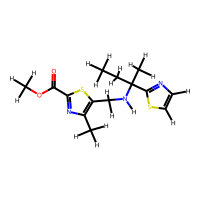
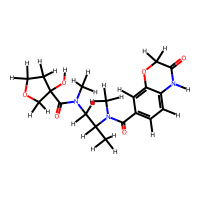
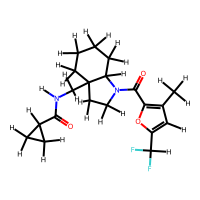
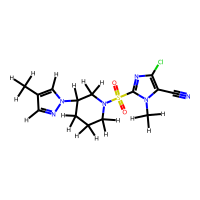
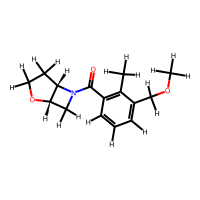
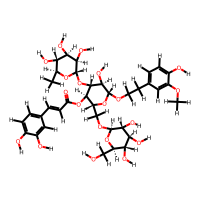
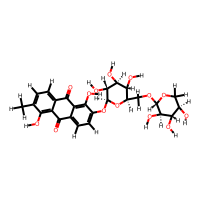
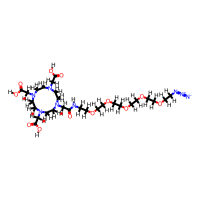
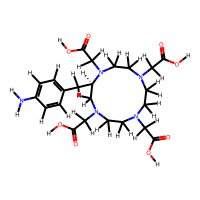
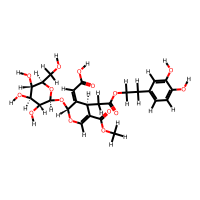

In [15]:
table

Vemos moleculas al azar

## Calculamos los descriptores 1D para comenzar a filtrar
Para esto se puede usar Descriptors de RD Kit. 
Sugencia: Armar un interable

In [29]:
bar=progressbar.ProgressBar(maxval=len(table["smiles"]))
table2=pd.DataFrame()
for i,smil in enumerate(table["smiles"]):

    mol = Chem.MolFromSmiles(smil) 
    table2.loc[i,'smiles']=table["smiles"][i]
    table2.loc[i,'id']=table["id"][i]
    table2.loc[i,'Mol']= mol 
    table2.loc[i,'MolWt']=Descriptors.MolWt(mol)
    table2.loc[i,'LogP']=Descriptors.MolLogP(mol)
    table2.loc[i,'NumHAcceptors']=Descriptors.NumHAcceptors(mol)
    table2.loc[i,'NumHDonors']=Descriptors.NumHDonors(mol)
    table2.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
    table2.loc[i,'NumRotatableBonds']=Descriptors.NumRotatableBonds(mol)
    table2.loc[i,'NumHeavyAtoms']=Descriptors.HeavyAtomCount (mol)

    bar.update(i+1)

  0% (0 of 59652) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (80 of 59652) |                     | Elapsed Time: 0:00:00 ETA:   0:01:15
  0% (158 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:16
  0% (238 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:15
  0% (318 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:15
  0% (398 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:14
  0% (459 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:17
  0% (536 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:17
  1% (613 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:17
  1% (690 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:17
  1% (756 of 59652) |                    | Elapsed Time: 0:00:00 ETA:   0:01:17
  1% (833 of 59652) |                    | Elapsed Time: 0:00:01 ETA:   0:01:17
  1% (904 of 59652) |                   

,smiles,id,Mol,MolWt,LogP,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumHeavyAtoms
0,CCC(C)(NCC1=C(C)N=C(C(=O)OC)S1)C1=NC=CS1,Z3802908175,,325.459,3.10962,7.0,1.0,7.0,6.0,21.0
1,CC(CN(C)C(=O)C1(O)CCOC1)N(C)C(=O)C1=CC=C2NC(=O...,PV-006986126441,,391.424,0.08780,6.0,2.0,9.0,5.0,28.0
2,CC1=C(C(=O)N2CCC3(CNC(=O)C4CC4)CCCCC23)OC(C(F)...,PV-004304002588,,380.435,3.82672,3.0,1.0,7.0,5.0,27.0
3,CC1=CN(C2CCCN(S(=O)(=O)C3=NC(Cl)=C(C#N)N3C)C2)...,Z3616737478,,368.850,1.47590,7.0,0.0,10.0,3.0,24.0
4,COCC1=CC=CC(C(=O)N2C[C@@H]3OCC[C@@H]32)=C1C |&...,Z5525936518,,261.321,1.75472,3.0,0.0,4.0,3.0,19.0
...,...,...,...,...,...,...,...,...,...,...
59647,COc1cc(CCO[C@@H]2O[C@H](CO[C@@H]3O[C@H](CO)[C@...,255227116,,800.760,-2.88870,20.0,11.0,20.0,14.0,56.0
59648,Cc1ccc2c(c1O)C(=O)c1ccc(O[C@@H]3O[C@H](CO[C@@H...,140283059,,564.496,-2.17638,14.0,8.0,14.0,5.0,40.0
59649,[N-]=[N+]=NCCOCCOCCOCCOCCOCCNC(=O)CN1CCN(CC(=O...,1857523819,,692.768,-2.02870,14.0,4.0,20.0,26.0,48.0
59650,Nc1ccc(C[C@@H]2CN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=...,34602851,,509.560,-1.26010,9.0,5.0,13.0,10.0,36.0

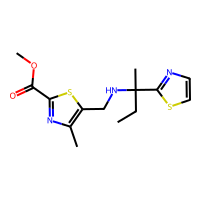
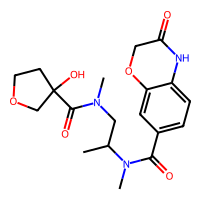
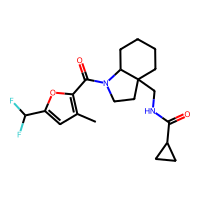
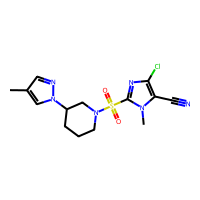
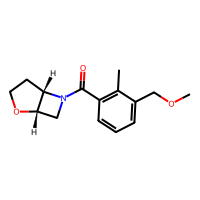
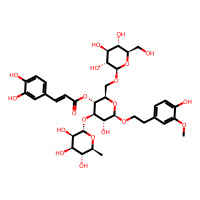
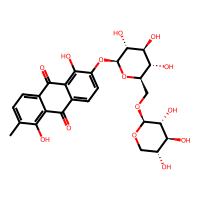
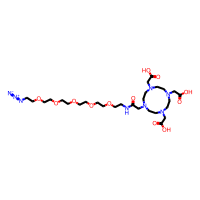
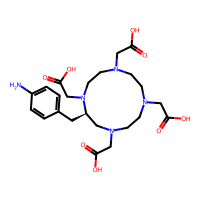
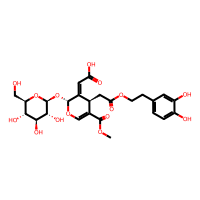

In [30]:
table2

## Calculamos histogramas 

Calcular los histogramas para tener nocion de la distribucion de los descriptores

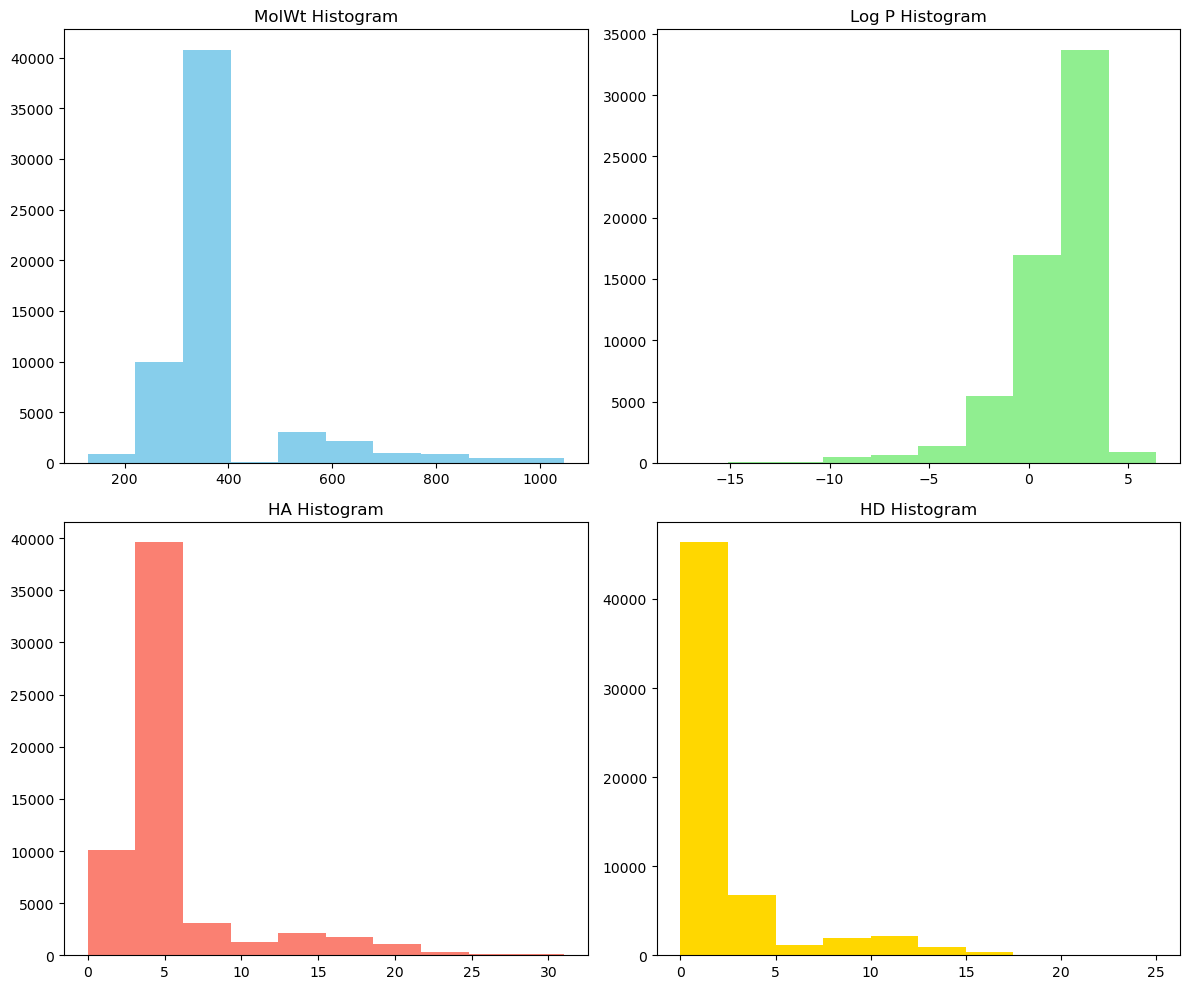

In [31]:
# Crear una figura con 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Graficar los histogramas en cada subplot
axs[0, 0].hist(table2['MolWt'], bins=10, color='skyblue')
axs[0, 0].set_title('MolWt Histogram')

axs[0, 1].hist(table2['LogP'], bins=10, color='lightgreen')
axs[0, 1].set_title('Log P Histogram')

axs[1, 0].hist(table2['NumHAcceptors'], bins=10, color='salmon')
axs[1, 0].set_title('HA Histogram')

axs[1, 1].hist(table2['NumHDonors'], bins=10, color='gold')
axs[1, 1].set_title('HD Histogram')

# Ajustar el layout para que los subplots no se superpongan
plt.tight_layout()

# Mostrar la figura
plt.show()

## Filtramos la base usando la regla de los 5

Describir regla

In [32]:
filtered_df= table2[table2['MolWt'] < 501]
filtered_df = filtered_df[filtered_df['LogP'] < 5]
filtered_df = filtered_df[filtered_df['LogP']  > -1]

,smiles,id,Mol,MolWt,LogP,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumHeavyAtoms
0,CCC(C)(NCC1=C(C)N=C(C(=O)OC)S1)C1=NC=CS1,Z3802908175,,325.459,3.10962,7.0,1.0,7.0,6.0,21.0
1,CC(CN(C)C(=O)C1(O)CCOC1)N(C)C(=O)C1=CC=C2NC(=O...,PV-006986126441,,391.424,0.08780,6.0,2.0,9.0,5.0,28.0
2,CC1=C(C(=O)N2CCC3(CNC(=O)C4CC4)CCCCC23)OC(C(F)...,PV-004304002588,,380.435,3.82672,3.0,1.0,7.0,5.0,27.0
3,CC1=CN(C2CCCN(S(=O)(=O)C3=NC(Cl)=C(C#N)N3C)C2)...,Z3616737478,,368.850,1.47590,7.0,0.0,10.0,3.0,24.0
4,COCC1=CC=CC(C(=O)N2C[C@@H]3OCC[C@@H]32)=C1C |&...,Z5525936518,,261.321,1.75472,3.0,0.0,4.0,3.0,19.0
...,...,...,...,...,...,...,...,...,...,...
55302,O=C(Nc1ccc(S(=O)(=O)Cl)cc1Br)c1ccc(I)cc1,59082071,,500.539,4.23350,3.0,1.0,8.0,3.0,21.0
55353,O=C(Nc1ccc(S(=O)(=O)Cl)cc1Br)c1ccccc1I,59075423,,500.539,4.23350,3.0,1.0,8.0,3.0,21.0
55381,O=C(Nc1ccc(S(=O)(=O)Cl)c(Br)c1)c1cccc(I)c1,59082100,,500.539,4.23350,3.0,1.0,8.0,3.0,21.0
55388,O=C(Nc1ccc(S(=O)(=O)Cl)c(Br)c1)c1ccccc1I,59060094,,500.539,4.23350,3.0,1.0,8.0,3.0,21.0

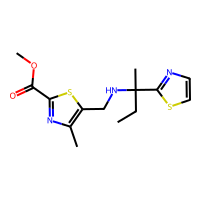
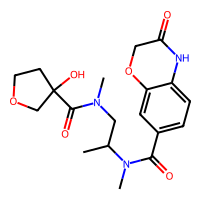
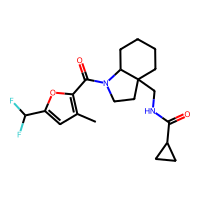
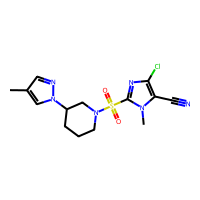
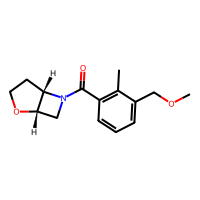
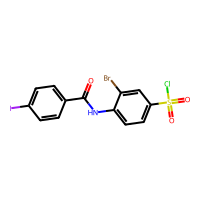
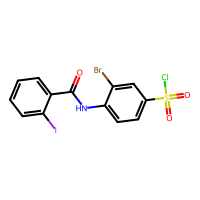
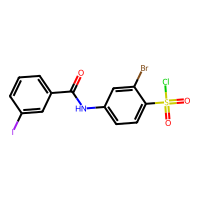
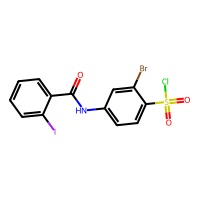
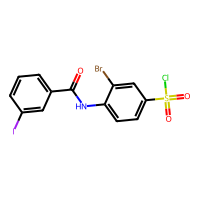

In [33]:
filtered_df

## Filtrar HA y HD!!

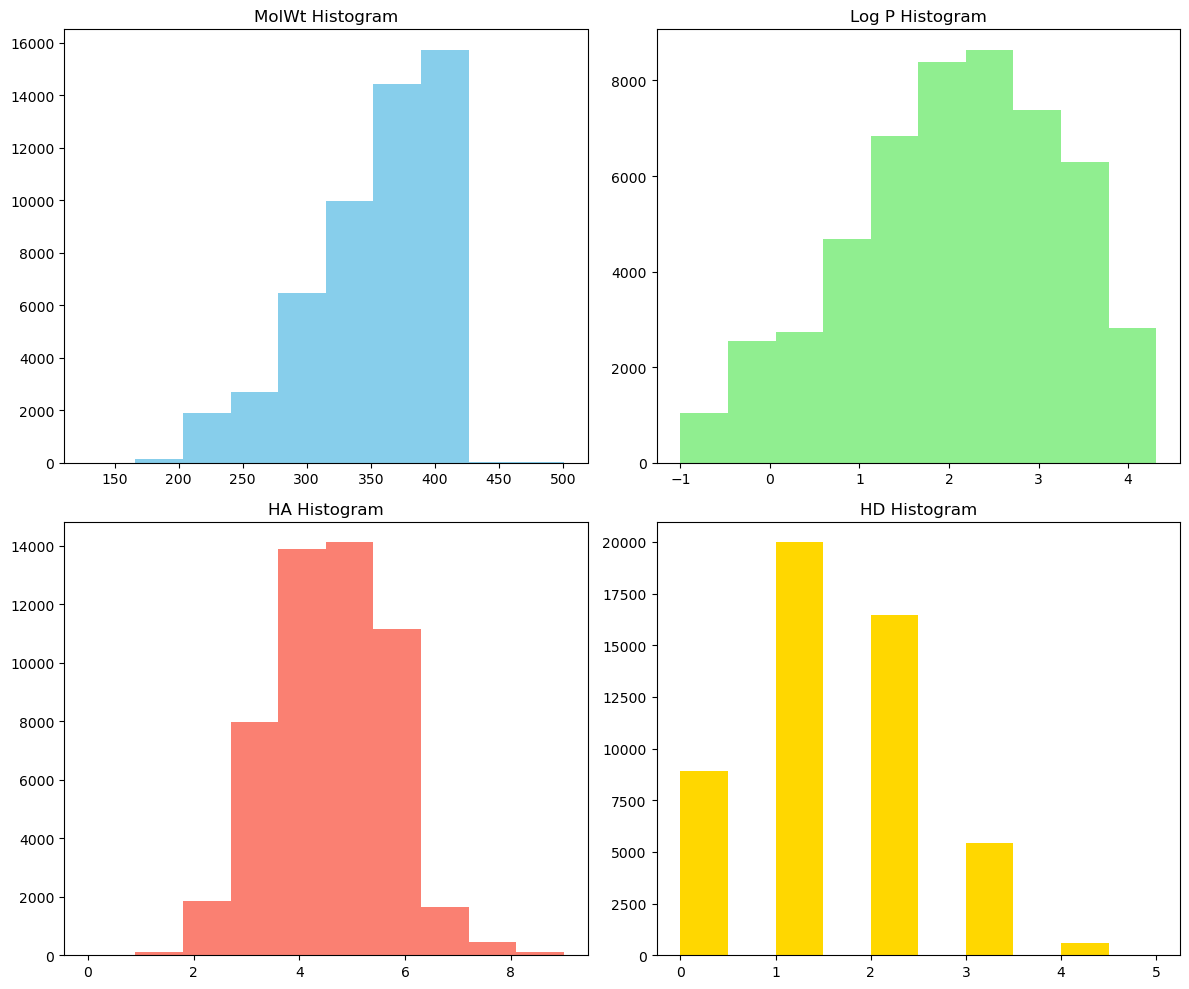

In [34]:
# Crear una figura con 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Graficar los histogramas en cada subplot
axs[0, 0].hist(filtered_df['MolWt'], bins=10, color='skyblue')
axs[0, 0].set_title('MolWt Histogram')

axs[0, 1].hist(filtered_df['LogP'], bins=10, color='lightgreen')
axs[0, 1].set_title('Log P Histogram')

axs[1, 0].hist(filtered_df['NumHAcceptors'], bins=10, color='salmon')
axs[1, 0].set_title('HA Histogram')

axs[1, 1].hist(filtered_df['NumHDonors'], bins=10, color='gold')
axs[1, 1].set_title('HD Histogram')

# Ajustar el layout para que los subplots no se superpongan
plt.tight_layout()

# Mostrar la figura
plt.show()

# Filtrar la base para eliminar los PAINS

In [27]:
# ver: https://projects.volkamerlab.org/teachopencadd/talktorials/T003_compound_unwanted_substructures.html

In [119]:
custom_pains = {
    "> 2 ester groups": "C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]",
    "2-halo pyridine": "n1c([F,Cl,Br,I])cccc1",
    "acid halide": "C(=O)[Cl,Br,I,F]",
    "acyclic C=C-O": "C=[C!r]O",
    "acyl cyanide": "N#CC(=O)",
    "acyl hydrazine": "C(=O)N[NH2]",
    "aldehyde": "[CH1](=O)",
    "Aliphatic long chain": "[R0;D2][R0;D2][R0;D2][R0;D2]",
    "alkyl halide": "[CX4][Cl,Br,I]",
    "amidotetrazole": "c1nnnn1C=O",
    "aniline": "c1cc([NH2])ccc1",
    "azepane": "[CH2R2]1N[CH2R2][CH2R2][CH2R2][CH2R2][CH2R2]1",
    "Azido group": "N=[N+]=[N-]",
    "Azo group": "N#N",
    "azocane": "[CH2R2]1N[CH2R2][CH2R2][CH2R2][CH2R2][CH2R2][CH2R2]1",
    "benzidine": "[cR2]1[cR2][cR2]([Nv3X3,Nv4X4])[cR2][cR2][cR2]1[cR2]2[cR2][cR2][cR2]([Nv3X3,Nv4X4])[cR2][cR2]2",
    "beta-keto/anhydride": "[C,c](=O)[CX4,CROX3,O][C,c](=O)",
    "biotin analogue": "C12C(NC(N1)=O)CSC2",
    "Carbo cation/anion": "[C+,c+,C-,c-]",
    "catechol": "c1c([OH])c([OH,NH2,NH])ccc1",
    "charged oxygen or sulfur atoms": "[O+,o+,S+,s+]",
    "chinone 1": "C1(=[O,N])C=CC(=[O,N])C=C1",
    "chinone 2": "C1(=[O,N])C(=[O,N])C=CC=C1",
    "conjugated nitrile group": "C=[C!r]C#N",
    "crown ether": "[OR2,NR2]@[CR2]@[CR2]@[OR2,NR2]@[CR2]@[CR2]@[OR2,NR2]",
    "cumarine": "c1ccc2c(c1)ccc(=O)o2",
    "cyanamide": "N[CH2]C#N",
    "cyanate / aminonitrile / thiocyanate": "[N,O,S]C#N",
    "cyanohydrins": "N#CC[OH]",
    "cycloheptane 1": "[CR2]1[CR2][CR2][CR2][CR2][CR2][CR2]1",
    "cycloheptane 2": "[CR2]1[CR2][CR2]cc[CR2][CR2]1",
    "cyclooctane 1": "[CR2]1[CR2][CR2][CR2][CR2][CR2][CR2][CR2]1",
    "cyclooctane 2": "[CR2]1[CR2][CR2]cc[CR2][CR2][CR2]1",
    "diaminobenzene 1": "[cR2]1[cR2]c([N+0X3R0,nX3R0])c([N+0X3R0,nX3R0])[cR2][cR2]1",
    "diaminobenzene 2": "[cR2]1[cR2]c([N+0X3R0,nX3R0])[cR2]c([N+0X3R0,nX3R0])[cR2]1",
    "diaminobenzene 3": "[cR2]1[cR2]c([N+0X3R0,nX3R0])[cR2][cR2]c1([N+0X3R0,nX3R0])",
    "diazo group": "[N!R]=[N!R]",
    "diketo group": "[C,c](=O)[C,c](=O)",
    "disulphide": "SS",
    "enamine": "[CX2R0][NX3R0]",
    "ester of HOBT": "C(=O)Onnn",
    "four member lactones": "C1(=O)OCC1",
    "halogenated ring 1": "c1cc([Cl,Br,I,F])cc([Cl,Br,I,F])c1[Cl,Br,I,F]",
    "halogenated ring 2": "c1ccc([Cl,Br,I,F])c([Cl,Br,I,F])c1[Cl,Br,I,F]",
    "heavy metal": "[Hg,Fe,As,Sb,Zn,Se,se,Te,B,Si]",
    "het-C-het not in ring": "[NX3R0,NX4R0,OR0,SX2R0][CX4][NX3R0,NX4R0,OR0,SX2R0]",
    "hydantoin": "C1NC(=O)NC(=O)1",
    "hydrazine": "N[NH2]",
    "hydroquinone": "[OH]c1ccc([OH,NH2,NH])cc1",
    "hydroxamic acid": "C(=O)N[OH]",
    "imine 1": "C=[N!R]",
    "imine 2": "N=[CR0][N,n,O,S]",
    "iodine": "I",
    "isocyanate": "N=C=O",
    "isolated alkene": "[$([CH2]),$([CH][CX4]),$(C([CX4])[CX4])]=[$([CH2]),$([CH][CX4]),$(C([CX4])[CX4])]",
    "ketene": "C=C=O",
    "methylidene-1,3 dithiole": "S1C=CSC1=S",
    "Michael acceptor 1": "C=!@CC=[O,S]",
    "Michael acceptor 2": "[$([CH]),$(CC)]#CC(=O)[C,c]",
    "Michael acceptor 3": "[$([CH]),$(CC)]#CS(=O)(=O)[C,c]",
    "Michael acceptor 4": "C=C(C=O)C=O",
    "Michael acceptor 5": "[$([CH]),$(CC)]#CC(=O)O[C,c]",
    "N oxide": "[NX2,nX3][OX1]",
    "N-acyl-2-amino-5 mercapto-1,3,4 thiadiazole": "s1c(S)nnc1NC=O",
    "N-C-halo": "NC[F,Cl,Br,I]",
    "N-halo": "[NX3,NX4][F,Cl,Br,I]",
    "N-hydroxyl pyridine": "n[OH]",
    "nitro group": "[N+](=O)[O-]",
    "N-nitroso": "[#7]-N=O",
    "oxime 1": "[C,c]=N[OH]",
    "oxime 2": "[C,c]=NOC=O",
    "Oxygen-nitrogen single bond": "[OR0,NR0][OR0,NR0]",
    "perfluorinated chain": "[CX4](F)(F)[CX4](F)F",
    "peroxide": "OO",
    "phenol ester": "c1ccccc1OC(=O)[#6]",
    "phenyl carbonate": "c1ccccc1OC(=O)O",
    "phosphor": "P",
    "phthalimide": "[cR,CR]~C(=O)NC(=O)~[cR,CR]",
    "Polycyclic aromatic hydrocarbon 1": "a1aa2a3a(a1)A=AA=A3=AA=A2",
    "Polycyclic aromatic hydrocarbon 2": "a21aa3a(aa1aaaa2)aaaa3",
    "Polycyclic aromatic hydrocarbon 3" : "a31a(a2a(aa1)aaaa2)aaaa3",
    "polyene": "[CR0]=[CR0][CR0]=[CR0]",
    "quaternary nitrogen 1": "[s,S,c,C,n,N,o,O]~[nX3+,NX3+](~[s,S,c,C,n,N])~[s,S,c,C,n,N]",
    "quaternary nitrogen 2": "[s,S,c,C,n,N,o,O]~[n+,N+](~[s,S,c,C,n,N,o,O])(~[s,S,c,C,n,N,o,O])~[s,S,c,C,n,N,o,O]",
    "quaternary nitrogen 3": "[*]=[N+]=[*]",
    "saponine derivative": "O1CCCCC1OC2CCC3CCCCC3C2",
    "silicon halogen": "[Si][F,Cl,Br,I]",
    "stilbene": "c1ccccc1C=Cc2ccccc2",
    "sulfinic acid": "[SX3](=O)[O-,OH]",
    "Sulfonic acid 2": "[C,c]S(=O)(=O)O[C,c]",
    "Sulfonic acid 3": "S(=O)(=O)[O-,OH]",
    "sulfonyl cyanide": "S(=O)(=O)C#N",
    "sulfur oxygen single bond": "[SX2]O",
    "sulphate": "OS(=O)(=O)[O-]",
    "sulphur nitrogen single bond": "[SX2H0][N]",
    "Thiobenzothiazole 1": "c12ccccc1(SC(S)=N2)",
    "Thiobenzothiazole 2": "c12ccccc1(SC(=S)N2)",
    "Thiocarbony1 group": "[C,c]=S",
    "thioester": "SC=O",
    "thiol 1": "[S-]",
    "thiol 2": "[SH]",
    "Three-membered heterocycle": "*1[!O,S,N]*1",
    "triflate": "OS(=O)(=O)C(F)(F)F",
    "triphenyl methylsilyl": "[SiR0,CR0](c1ccccc1)(c2ccccc2)c3ccccc3",
    "triple bond": "C#C"
}

# Verificar los resultados
for key, value in custom_pains.items():
    print(f"{key}: {value}")


# Convertir el diccionario a un DataFrame
substructures_df = pd.DataFrame(list(custom_pains.items()), columns=['name', 'smarts'])

# Mostrar el DataFrame
substructures_df



> 2 ester groups: C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]
2-halo pyridine: n1c([F,Cl,Br,I])cccc1
acid halide: C(=O)[Cl,Br,I,F]
acyclic C=C-O: C=[C!r]O
acyl cyanide: N#CC(=O)
acyl hydrazine: C(=O)N[NH2]
aldehyde: [CH1](=O)
Aliphatic long chain: [R0;D2][R0;D2][R0;D2][R0;D2]
alkyl halide: [CX4][Cl,Br,I]
amidotetrazole: c1nnnn1C=O
aniline: c1cc([NH2])ccc1
azepane: [CH2R2]1N[CH2R2][CH2R2][CH2R2][CH2R2][CH2R2]1
Azido group: N=[N+]=[N-]
Azo group: N#N
azocane: [CH2R2]1N[CH2R2][CH2R2][CH2R2][CH2R2][CH2R2][CH2R2]1
benzidine: [cR2]1[cR2][cR2]([Nv3X3,Nv4X4])[cR2][cR2][cR2]1[cR2]2[cR2][cR2][cR2]([Nv3X3,Nv4X4])[cR2][cR2]2
beta-keto/anhydride: [C,c](=O)[CX4,CROX3,O][C,c](=O)
biotin analogue: C12C(NC(N1)=O)CSC2
Carbo cation/anion: [C+,c+,C-,c-]
catechol: c1c([OH])c([OH,NH2,NH])ccc1
charged oxygen or sulfur atoms: [O+,o+,S+,s+]
chinone 1: C1(=[O,N])C=CC(=[O,N])C=C1
chinone 2: C1(=[O,N])C(=[O,N])C=CC=C1
conjugated nitrile group: C=[C!r]C#N
crown ether: [OR2,NR2]@[CR2]@[CR2]@[OR2,NR2]@[CR2]@[CR2]@[OR2,NR

,name,smarts
0,> 2 ester groups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]"
1,2-halo pyridine,"n1c([F,Cl,Br,I])cccc1"
2,acid halide,"C(=O)[Cl,Br,I,F]"
3,acyclic C=C-O,C=[C!r]O
4,acyl cyanide,N#CC(=O)
...,...,...
100,thiol 2,[SH]
101,Three-membered heterocycle,"*1[!O,S,N]*1"
102,triflate,OS(=O)(=O)C(F)(F)F
103,triphenyl methylsilyl,"[SiR0,CR0](c1ccccc1)(c2ccccc2)c3ccccc3"


In [120]:
# Convertir la columna 'smarts' a objetos RDKit Mol
substructures_df["rdkit_molecule"] = substructures_df.smarts.apply(Chem.MolFromSmarts)

# Imprimir el número de subestructuras no deseadas en la colección
print("Number of unwanted substructures in collection:", len(substructures_df))

Number of unwanted substructures in collection: 105


,name,smarts,rdkit_molecule
0,> 2 ester groups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]",
1,2-halo pyridine,"n1c([F,Cl,Br,I])cccc1",
2,acid halide,"C(=O)[Cl,Br,I,F]",
3,acyclic C=C-O,C=[C!r]O,
4,acyl cyanide,N#CC(=O),
...,...,...,...
100,thiol 2,[SH],
101,Three-membered heterocycle,"*1[!O,S,N]*1",
102,triflate,OS(=O)(=O)C(F)(F)F,
103,triphenyl methylsilyl,"[SiR0,CR0](c1ccccc1)(c2ccccc2)c3ccccc3",

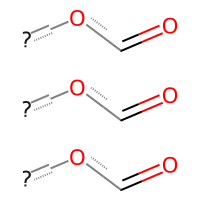
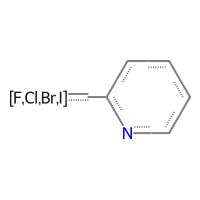
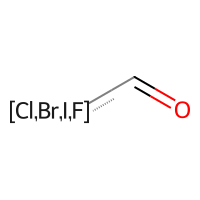
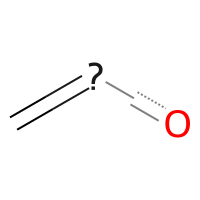
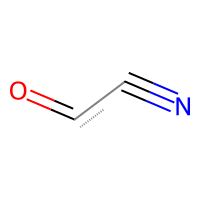
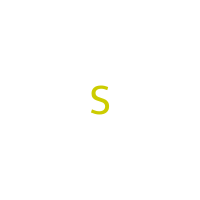
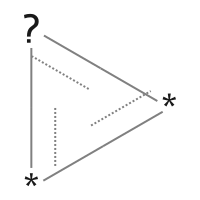
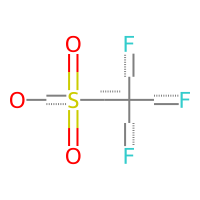
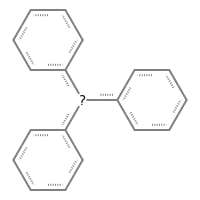
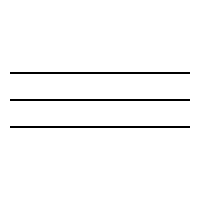

In [121]:
substructures_df

In [122]:
import pandas as pd
from rdkit import Chem
import progressbar

# Asume que filtered_df tiene una columna 'id' y una columna 'Mol' con objetos RDKit Mol

# Listas para almacenar los resultados
matches = []
clean = []

# Configurar la barra de progreso
bar = progressbar.ProgressBar(max_value=len(filtered_df))

# Búsqueda de subestructuras no deseadas
for index, row in enumerate(filtered_df.itertuples(index=False)):
    molecule = row.Mol
    molecule_id = row.id
    match = False
    for _, substructure in substructures_df.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "id": molecule_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
            break  # Si se encuentra una coincidencia, salir del bucle interno
    if not match:
        clean.append(index)
    
    # Actualizar la barra de progreso
    bar.update(index + 1)

# Convertir la lista de matches a un DataFrame
matches_df = pd.DataFrame(matches)

# Filtrar el DataFrame original para eliminar las filas con subestructuras no deseadas
df_filtrado2 = filtered_df.iloc[clean]

# Mostrar los resultados
print("Matches:")
print(matches_df)
print("\nClean DataFrame:")
print(df_filtrado2)

  0% (0 of 51370) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (23 of 51370) |                     | Elapsed Time: 0:00:00 ETA:   0:03:50
  0% (45 of 51370) |                     | Elapsed Time: 0:00:00 ETA:   0:03:56
  0% (65 of 51370) |                     | Elapsed Time: 0:00:00 ETA:   0:04:03
  0% (86 of 51370) |                     | Elapsed Time: 0:00:00 ETA:   0:04:04
  0% (108 of 51370) |                    | Elapsed Time: 0:00:00 ETA:   0:04:03
  0% (130 of 51370) |                    | Elapsed Time: 0:00:00 ETA:   0:04:01
  0% (152 of 51370) |                    | Elapsed Time: 0:00:00 ETA:   0:04:01
  0% (174 of 51370) |                    | Elapsed Time: 0:00:00 ETA:   0:04:00
  0% (196 of 51370) |                    | Elapsed Time: 0:00:00 ETA:   0:04:00
  0% (218 of 51370) |                    | Elapsed Time: 0:00:01 ETA:   0:03:59
  0% (240 of 51370) |                    | Elapsed Time: 0:00:01 ETA:   0:03:59
  0% (262 of 51370) |                   

Matches:
                   id                                    rdkit_molecule  \
0     PV-004304002588  <rdkit.Chem.rdchem.Mol object at 0x7f1bc188f990>   
1     PV-009821869757  <rdkit.Chem.rdchem.Mol object at 0x7f1bc18d3760>   
2     PV-004811760652  <rdkit.Chem.rdchem.Mol object at 0x7f1bc1ce6e30>   
3     PV-007658655156  <rdkit.Chem.rdchem.Mol object at 0x7f1bc1ce7df0>   
4     PV-010030592061  <rdkit.Chem.rdchem.Mol object at 0x7f1bc1ce70d0>   
...               ...                                               ...   
9994         59082071  <rdkit.Chem.rdchem.Mol object at 0x7f1bc1354e40>   
9995         59075423  <rdkit.Chem.rdchem.Mol object at 0x7f1bc1355fc0>   
9996         59082100  <rdkit.Chem.rdchem.Mol object at 0x7f1bc13570d0>   
9997         59060094  <rdkit.Chem.rdchem.Mol object at 0x7f1bc1357450>   
9998         59082099  <rdkit.Chem.rdchem.Mol object at 0x7f1bc1358890>   

                                          substructure  \
0     <rdkit.Chem.rdchem.Mol obj

,smiles,id,Mol,MolWt,LogP,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumHeavyAtoms
0,CCC(C)(NCC1=C(C)N=C(C(=O)OC)S1)C1=NC=CS1,Z3802908175,,325.459,3.10962,7.0,1.0,7.0,6.0,21.0
1,CC(CN(C)C(=O)C1(O)CCOC1)N(C)C(=O)C1=CC=C2NC(=O...,PV-006986126441,,391.424,0.08780,6.0,2.0,9.0,5.0,28.0
3,CC1=CN(C2CCCN(S(=O)(=O)C3=NC(Cl)=C(C#N)N3C)C2)...,Z3616737478,,368.850,1.47590,7.0,0.0,10.0,3.0,24.0
4,COCC1=CC=CC(C(=O)N2C[C@@H]3OCC[C@@H]32)=C1C |&...,Z5525936518,,261.321,1.75472,3.0,0.0,4.0,3.0,19.0
5,CC(=O)OCCC(=O)NCC1CN(C(=O)[C@@H]2CNC(=O)N2)C(C...,PV-003048488104,,354.407,-0.63570,5.0,3.0,9.0,6.0,25.0
...,...,...,...,...,...,...,...,...,...,...
51850,O=S1(=O)CCN(S(=O)(=O)Cl)CC1,59352330,,233.698,-0.79960,4.0,0.0,8.0,1.0,12.0
51851,O=S1(=O)CC[C@H](S(=O)(=O)Cl)C1,95686536,,218.683,-0.25790,4.0,0.0,7.0,1.0,11.0
51852,NS(=O)(=O)c1ccc(S(=O)(=O)F)cc1,164418209,,239.249,-0.00780,4.0,1.0,8.0,2.0,14.0
51853,CCc1cc(C(=O)NCc2n[nH]c(=O)[nH]2)ccn1,218169752,,247.258,-0.01460,4.0,3.0,7.0,4.0,18.0

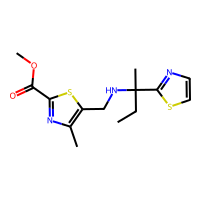
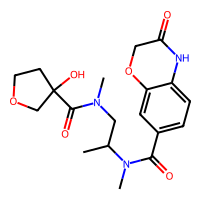
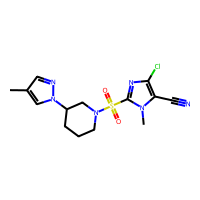
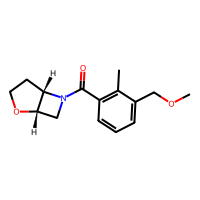
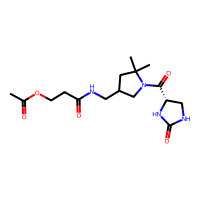
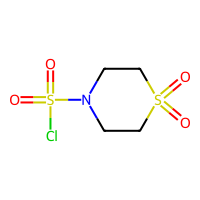
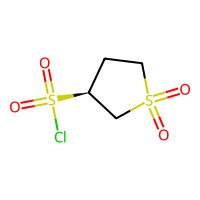
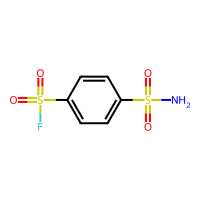
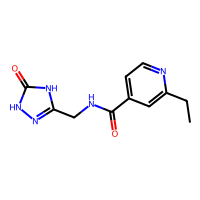
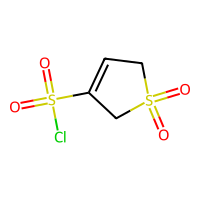

In [124]:
df_filtrado2

,id,rdkit_molecule,substructure,substructure_name
9854,100634951,,,aldehyde
9985,59688640,,,aldehyde

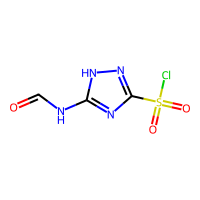
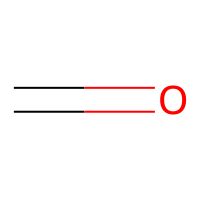
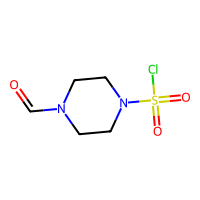
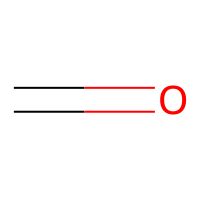

In [128]:
matches_df[matches_df["substructure_name"] =="aldehyde"]

In [126]:
groups = matches_df.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies

substructure_name
Three-membered heterocycle     9703
Aliphatic long chain            139
beta-keto/anhydride              53
iodine                           24
hydantoin                        14
phthalimide                      11
diketo group                      9
isolated alkene                   7
heavy metal                       6
Oxygen-nitrogen single bond       6
Michael acceptor 1                5
alkyl halide                      3
Thiocarbony1 group                3
het-C-het not in ring             3
imine 1                           3
> 2 ester groups                  3
aldehyde                          2
cyanamide                         1
Sulfonic acid 3                   1
ester of HOBT                     1
hydrazine                         1
nitro group                       1
dtype: int64